<ipython-input-6-46477c4acfce>:14: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-6-46477c4acfce>:14: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-6-46477c4acfce>:14: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
<ipython-input-6-46477c4acfce>:14: RuntimeWarning: invalid value encountered in true_divide
  abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


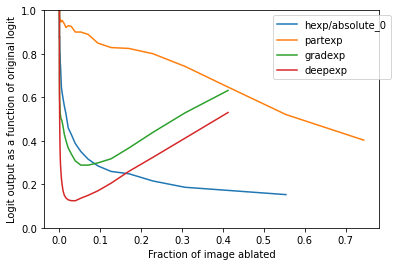

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt

# exp_x = np.linspace(-1, 0, 20)
# perturbation_sizes = np.sort(1.1 - 10 ** (exp_x))
A = 1200*1600
exp_x = np.linspace(np.log10(1/A), 0, 50)
relative_perturbation_sizes = np.concatenate(([0], np.sort(10 ** (exp_x))))
exp_mapper = ["hexp/absolute_0", "partexp", "gradexp", "deepexp"]

for exp_name in exp_mapper:
    LOR = np.load(os.path.join("LOR", "%s/results.npy" % exp_name))
    abl_curve = np.true_divide(LOR.sum(0),(LOR!=0).sum(0))
    plt.plot(relative_perturbation_sizes, abl_curve, label=exp_name)

# plt.xscale("log")
# plt.plot(relative_perturbation_sizes, np.log10(0.0935) * np.ones(len(relative_perturbation_sizes)), '-.k')    
plt.legend(bbox_to_anchor=(1.05, 1))      
plt.xlabel("Fraction of image ablated")
plt.ylabel("Logit output as a function of original logit")
plt.ylim([0, 1])
plt.savefig("LOR.eps")

In [2]:
import pandas as pd
from sklearn import metrics
import torch

df_training = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/training.json")
df_test = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/test_cropped.json")
frames = [df_training, df_test]
df_merged = pd.concat(frames, ignore_index=True)
# ADD IMAGE_NAME COLUMN TO DATAFRAME
image_names = []
for i, row in df_merged.iterrows():
    image_names.append(os.path.basename(row["image"]["pathname"]))
df_merged["image_name"] = image_names

true_positives = np.load("true_positives.npy", allow_pickle=True)
data = []
for exp_name in exp_mapper:
    scores = []
    explanation_dir = os.path.join("true_positive_explanations", exp_name)
    for i, image in enumerate(true_positives.item()["1"]):
        ground_truth = np.zeros((1200, 1600))
        image_name = os.path.basename(image)
        query = df_merged.loc[df_merged["image_name"] == image_name]
        # print(image_name)
        for i, row in query.iterrows():
            print(exp_name, image_name)
            cells = row["objects"]
            for cell in cells:
                cell_class = cell["category"]
                if cell_class == "trophozoite":
                    bbox = cell["bounding_box"]
                    upper_left_r = bbox["minimum"]["r"]
                    upper_left_c = bbox["minimum"]["c"]
                    lower_right_r = bbox["maximum"]["r"]
                    lower_right_c = bbox["maximum"]["c"]
                    # print(upper_left_r, upper_left_c, lower_right_r, lower_right_c)
                    ground_truth[upper_left_r:lower_right_r+1, upper_left_c:lower_right_c+1] = 1
        if exp_name == "naive":
            explanation = torch.rand(1200, 1600) + .5
        else:
            explanation = np.load(os.path.join(explanation_dir, "%s.npy" % image_name))
        # plt.imshow(ground_truth, cmap="bwr")
        # plt.show()
        # plt.imshow(explanation > 1e-10, cmap="bwr")
        # plt.show()
        score = metrics.f1_score(ground_truth.flatten(), explanation.flatten() > 1e-10)
        # print(score)
        scores.append(score)
    data.append(scores)

hexp/absolute_0 005e60b6-77b8-458c-b57c-bfe0c7e7df78.png


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1, 1)
ax.boxplot(data, labels=exp_mapper)
ax.set_ylim([1e-3, 5e-1])
ax.set_yscale("log")
fig.suptitle(r"$F_1$ scores")
plt.savefig("f1_scores.eps")